In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from epinterface.geometry import compute_shading_mask
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm

specs_df = pd.read_parquet(
    "C:/Users/szvsw/repos/bayesian-ubem/notebooks/cache/result-specs-with-neighbors.pq"
).sort_values(by="sort_index")
results_df = pd.read_hdf(
    "C:/Users/szvsw/repos/bayesian-ubem/notebooks/cache/results.h5",
).sort_index(level="sort_index")

target_columns = results_df.columns.tolist()

In [2]:
def compute_errs(
    model: xgb.Booster,
    features: pd.DataFrame,
    targets: np.ndarray,
    target_columns: list[str],
) -> pd.DataFrame:
    dmat = xgb.DMatrix(features, label=targets)
    preds = model.predict(dmat)
    trues = targets
    # trues = targets[target_columns].values
    err_df = {}
    for i, col in enumerate(target_columns):
        pred_col = preds[:, i]
        true_col = trues[:, i]
        if "cooling" in col.lower():
            true_col = true_col / 2  # assume worst possible cooling cop
            pred_col = pred_col / 2  # assume worst possible cooling cop
        if "heating" in col.lower():
            true_col = true_col / 0.8  # assume worst possible heating cop
            pred_col = pred_col / 0.8  # assume worst possible heating cop
        r2 = r2_score(true_col, pred_col)
        mae = mean_absolute_error(true_col, pred_col)
        mape = mean_absolute_percentage_error(true_col, pred_col)
        mse = mean_squared_error(true_col, pred_col)
        rmse = np.sqrt(mse)
        cvrmse = rmse / true_col.mean()
        err_df[col] = pd.Series({
            "mae": mae,
            "mape": mape,
            "rmse": rmse,
            "cvrmse": cvrmse,
            "r2": -r2,
        })

    err_df = pd.DataFrame(err_df)
    err_df.index.name = "metric"
    err_df.columns.name = "target"
    return err_df


def check_typology(row: pd.Series) -> int:
    if (
        (
            ("multi" in row["typology"].lower() or "mf" in row["typology"].lower())
            and "4 units" not in row["typology"].lower()
            and "3 units" not in row["typology"].lower()
        )
        or row["num_floors"] > 3
        or row["footprint_area"] > 1000
    ):
        return 0
    return 1

In [32]:
n = 100_000
test_size = 0.3
sample_mode = "STRATIFIED"
epw_ixs = []
train_ixs_by_epw = {}
test_ixs_by_epw = {}
train_ixs_by_epw_renumbered = {}
test_ixs_by_epw_renumbered = {}
total_train = 0
total_test = 0


if sample_mode == "STRATIFIED":
    epw_counts = specs_df["epwzip_path"].value_counts()
    epw_counts = epw_counts.iloc[epw_ixs] if len(epw_ixs) > 0 else epw_counts
    n_per_epw = int(n / len(epw_counts))
    train_ix = []
    test_ix = []
    for epw in epw_counts.index:
        mask = specs_df["epwzip_path"] == epw
        ixs = np.where(mask)[0]
        if mask.sum() < n_per_epw:
            n_train_epw = int(len(ixs) * (1 - test_size))
            train_ixs = np.random.choice(ixs, size=n_train_epw, replace=False)
            test_ixs = np.setdiff1d(ixs, train_ixs)
            train_ix.extend(train_ixs)
            test_ix.extend(test_ixs)
            train_ixs_by_epw[epw] = train_ixs
            test_ixs_by_epw[epw] = test_ixs
            train_ixs_by_epw_renumbered[epw] = np.arange(len(train_ixs)) + total_train
            test_ixs_by_epw_renumbered[epw] = np.arange(len(test_ixs)) + total_test
            total_train += len(train_ixs)
            total_test += len(test_ixs)
        else:
            ixs = np.random.choice(ixs, size=min(n_per_epw, len(ixs)), replace=False)
            train_ixs, test_ixs = train_test_split(
                ixs, test_size=test_size, random_state=42
            )
            train_ix.extend(train_ixs)
            test_ix.extend(test_ixs)
            train_ixs_by_epw[epw] = train_ixs
            test_ixs_by_epw[epw] = test_ixs
            train_ixs_by_epw_renumbered[epw] = np.arange(len(train_ixs)) + total_train
            test_ixs_by_epw_renumbered[epw] = np.arange(len(test_ixs)) + total_test
            total_train += len(train_ixs)
            total_test += len(test_ixs)
    train_ixs = np.array(train_ix)
    test_ixs = np.array(test_ix)
elif sample_mode == "RANDOM":
    ixs = np.random.choice(np.arange(len(specs_df)), size=n, replace=False)
    train_ixs, test_ixs = train_test_split(ixs, test_size=test_size, random_state=42)
else:
    msg = f"Invalid sample mode: {sample_mode}"
    raise ValueError(msg)

In [33]:
X_train = specs_df.iloc[train_ixs]
X_test = specs_df.iloc[test_ixs]
Y_train = results_df.iloc[train_ixs]
Y_test = results_df.iloc[test_ixs]
n_angles = 12

X_train_masks = np.array([
    compute_shading_mask(
        building=row["rotated_rectangle"],
        neighbors=row["neighbor_polys"],
        neighbor_floors=row["neighbor_floors"],
        neighbor_f2f_height=3.5,
        azimuthal_angle=2 * np.pi / n_angles,
    )
    for ix, row in X_train.iterrows()
])

X_test_masks = np.array([
    compute_shading_mask(
        building=row["rotated_rectangle"],
        neighbors=row["neighbor_polys"],
        neighbor_floors=row["neighbor_floors"],
        neighbor_f2f_height=3.5,
        azimuthal_angle=2 * np.pi / n_angles,
    )
    for ix, row in X_test.iterrows()
])

for i in range(X_train_masks.shape[1]):
    X_train[f"shading_mask_{i:02d}"] = X_train_masks[:, i]
    X_test[f"shading_mask_{i:02d}"] = X_test_masks[:, i]


In [34]:
feature_columns = [
    "footprint_area",
    "num_floors",
    "long_edge_angle",
    "long_edge",
    "short_edge",
    "rotated_rectangle_area_ratio",
] + [f"shading_mask_{i:02d}" for i in range(n_angles)]

# Weather file location handling
unique_epws = pd.concat([X_train["epwzip_path"], X_test["epwzip_path"]]).unique()
X_train_epw = pd.Categorical(X_train["epwzip_path"], categories=unique_epws)
X_test_epw = pd.Categorical(X_test["epwzip_path"], categories=unique_epws)
X_train_epw_onehot = pd.get_dummies(X_train_epw, prefix="epw").astype(int)
X_test_epw_onehot = pd.get_dummies(X_test_epw, prefix="epw").astype(int)
X_train_epw_onehot.index = X_train.index
X_test_epw_onehot.index = X_test.index
X_train_epw_codes = X_train_epw.codes.astype(int)
X_test_epw_codes = X_test_epw.codes.astype(int)


# typology handling
X_train_typology = X_train.apply(check_typology, axis=1)
X_test_typology = X_test.apply(check_typology, axis=1)

# Year built handling
X_train_year_bracket = pd.cut(
    X_train["year_built"], bins=[0000, 1974, 2003, 3000], labels=[0, 1, 2]
)
X_test_year_bracket = pd.cut(
    X_test["year_built"], bins=[0000, 1974, 2003, 3000], labels=[0, 1, 2]
)
X_train_year_bracket_onehot = pd.get_dummies(
    X_train_year_bracket, prefix="year_bracket"
).astype(int)
X_test_year_bracket_onehot = pd.get_dummies(
    X_test_year_bracket, prefix="year_bracket"
).astype(int)
X_train_year_bracket_codes = X_train_year_bracket.astype(int)
X_test_year_bracket_codes = X_test_year_bracket.astype(int)

# zoning handling
X_train_zoning = ((X_train["long_edge"] > 15) & (X_train["short_edge"] > 15)).astype(
    float
)
X_test_zoning = ((X_test["long_edge"] > 15) & (X_test["short_edge"] > 15)).astype(float)

# angle handling
X_train_angle = X_train["long_edge_angle"]
X_test_angle = X_test["long_edge_angle"]
X_train_angle_sin = np.sin(X_train_angle)
X_test_angle_sin = np.sin(X_test_angle)
X_train_angle_cos = np.cos(X_train_angle)
X_test_angle_cos = np.cos(X_test_angle)


X_train_features = pd.DataFrame({
    **X_train[feature_columns],
    **{"epw_code": X_train_epw_codes},
    **{"typology": X_train_typology},
    **{"year_bracket": X_train_year_bracket_codes},
    **{"zoning": X_train_zoning},
    **{"angle_sin": X_train_angle_sin},
    **{"angle_cos": X_train_angle_cos},
})
X_train_features = pd.concat(
    [X_train_features, X_train_year_bracket_onehot, X_train_epw_onehot], axis=1
)

X_test_features = pd.DataFrame({
    **X_test[feature_columns],
    **{"epw_code": X_test_epw_codes},
    **{"typology": X_test_typology},
    **{"year_bracket": X_test_year_bracket_codes},
    **{"zoning": X_test_zoning},
    **{"angle_sin": X_test_angle_sin},
    **{"angle_cos": X_test_angle_cos},
})
X_test_features = pd.concat(
    [X_test_features, X_test_year_bracket_onehot, X_test_epw_onehot], axis=1
)

# epw_counts_in_train = X_train_features["epw_code"].value_counts()
# for i in range(len(unique_epws)):
#     if i not in epw_counts_in_train.index:
#         print(f"epw {i} not in train")
#         epw_counts_in_train.loc[i] = 0

In [35]:
xgb_config = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "max_depth": 5,  # 7
    "eta": 0.1,
    "min_child_weight": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    # "alpha": 0.01,
    # "lambda": 0.01,
    # "gamma": 0.01,
}


train_dmatrix = xgb.DMatrix(X_train_features, label=Y_train[target_columns].values)
test_dmatrix = xgb.DMatrix(X_test_features, label=Y_test[target_columns].values)

model = xgb.train(
    xgb_config,
    train_dmatrix,
    num_boost_round=2000,
    evals=[(test_dmatrix, "test")],
    early_stopping_rounds=20,
    verbose_eval=True,
)


[0]	test-rmse:33.75041
[1]	test-rmse:30.73339
[2]	test-rmse:27.88937
[3]	test-rmse:25.31965
[4]	test-rmse:23.04563
[5]	test-rmse:20.99797
[6]	test-rmse:19.18762
[7]	test-rmse:17.59490
[8]	test-rmse:16.15554
[9]	test-rmse:14.87341
[10]	test-rmse:13.74386
[11]	test-rmse:12.73479
[12]	test-rmse:11.84726
[13]	test-rmse:11.06657
[14]	test-rmse:10.38224
[15]	test-rmse:9.80164
[16]	test-rmse:9.28364
[17]	test-rmse:8.82449
[18]	test-rmse:8.40940
[19]	test-rmse:8.05473
[20]	test-rmse:7.75431
[21]	test-rmse:7.48660
[22]	test-rmse:7.24650
[23]	test-rmse:7.03457
[24]	test-rmse:6.83774
[25]	test-rmse:6.66962
[26]	test-rmse:6.50036
[27]	test-rmse:6.36544
[28]	test-rmse:6.21278
[29]	test-rmse:6.09112
[30]	test-rmse:5.96668
[31]	test-rmse:5.86030
[32]	test-rmse:5.77296
[33]	test-rmse:5.66073
[34]	test-rmse:5.56028
[35]	test-rmse:5.48207
[36]	test-rmse:5.40911
[37]	test-rmse:5.33577
[38]	test-rmse:5.27007
[39]	test-rmse:5.20911
[40]	test-rmse:5.15222
[41]	test-rmse:5.09280
[42]	test-rmse:5.03526
[43]	t

In [36]:
err_comparator = pd.Series({
    "mae": 2.0,
    "mape": 0.1,
    "rmse": 2.5,
    "cvrmse": 0.1,
    "r2": -0.9,
})

err_comparator = pd.Series({
    "mae": 1.25,
    "mape": 0.05,
    "rmse": 1.75,
    "cvrmse": 0.05,
    "r2": -0.95,
})

In [37]:
def compute_progressive_model(
    X_train_features: pd.DataFrame,
    Y_train: pd.DataFrame,
    X_test_features: pd.DataFrame,
    Y_test: pd.DataFrame,
    target_columns: list[str],
    sample_frac_breakpoints: list[float],
    xgb_config: dict,
    num_boost_round: int,
    early_stopping_rounds: int,
    verbose_eval: bool,
    train_ixs_by_epw_renumbered: dict[str, np.ndarray],
    test_ixs_by_epw_renumbered: dict[str, np.ndarray],
    unique_epws: np.ndarray,
    test_size: float,
):
    unique_epw_codes = np.arange(len(unique_epws))
    n_available_sims = X_train_features.shape[0]
    all_err_dfs = {}
    for sample_frac in tqdm(
        sample_frac_breakpoints, total=len(sample_frac_breakpoints)
    ):
        all_train_ixs = []
        all_test_ixs = []
        samps_per_epw = int(n_available_sims / len(unique_epws) * sample_frac)
        n_train_samps = int(samps_per_epw * (1 - test_size))
        n_test_samps = int(samps_per_epw * test_size)
        for epw, epw_train_ixs in train_ixs_by_epw_renumbered.items():
            n_samples = min(n_train_samps, len(epw_train_ixs))
            epw_train_ixs = epw_train_ixs[:n_samples]
            all_train_ixs.extend(epw_train_ixs)

        for epw, epw_test_ixs in test_ixs_by_epw_renumbered.items():
            n_samples = min(n_test_samps, len(epw_test_ixs))
            epw_test_ixs = epw_test_ixs[:n_samples]
            all_test_ixs.extend(epw_test_ixs)

        X_train_features_subset = X_train_features.iloc[all_train_ixs]
        Y_train_subset = Y_train.iloc[all_train_ixs]
        X_test_features_subset = X_test_features.iloc[all_test_ixs]
        Y_test_subset = Y_test.iloc[all_test_ixs]

        train_dmatrix = xgb.DMatrix(
            X_train_features_subset, label=Y_train_subset[target_columns].values
        )
        test_dmatrix = xgb.DMatrix(
            X_test_features_subset, label=Y_test_subset[target_columns].values
        )

        model = xgb.train(
            xgb_config,
            train_dmatrix,
            num_boost_round=num_boost_round,
            evals=[(test_dmatrix, "test")],
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=verbose_eval,
        )

        err_dfs = {}
        for epw_code in unique_epw_codes:
            mask = X_test_features["epw_code"] == epw_code
            err_dfs[epw_code] = compute_errs(
                model,
                X_test_features[mask],
                Y_test[target_columns].values[mask],
                target_columns,
            )

        err_dfs = pd.concat(err_dfs, axis=1, names=["epw_code"]).T
        all_err_dfs[sample_frac] = err_dfs
    all_err_dfs = pd.concat(all_err_dfs, axis=0, names=["sample_frac"])
    return all_err_dfs


In [40]:
all_err_dfs = compute_progressive_model(
    X_train_features,
    Y_train,
    X_test_features,
    Y_test,
    target_columns,
    sample_frac_breakpoints=[
        0.01,
        0.05,
        0.1,
        0.15,
        0.2,
        0.25,
        0.3,
        0.35,
        0.4,
        0.45,
        0.5,
        0.55,
        0.6,
        0.65,
        0.7,
        0.75,
        0.8,
        0.85,
        0.9,
        0.95,
        1.0,
    ],
    xgb_config=xgb_config,
    num_boost_round=2000,
    early_stopping_rounds=20,
    verbose_eval=False,
    train_ixs_by_epw_renumbered=train_ixs_by_epw_renumbered,
    test_ixs_by_epw_renumbered=test_ixs_by_epw_renumbered,
    unique_epws=unique_epws,
    test_size=test_size,
)


  0%|          | 0/21 [00:00<?, ?it/s]

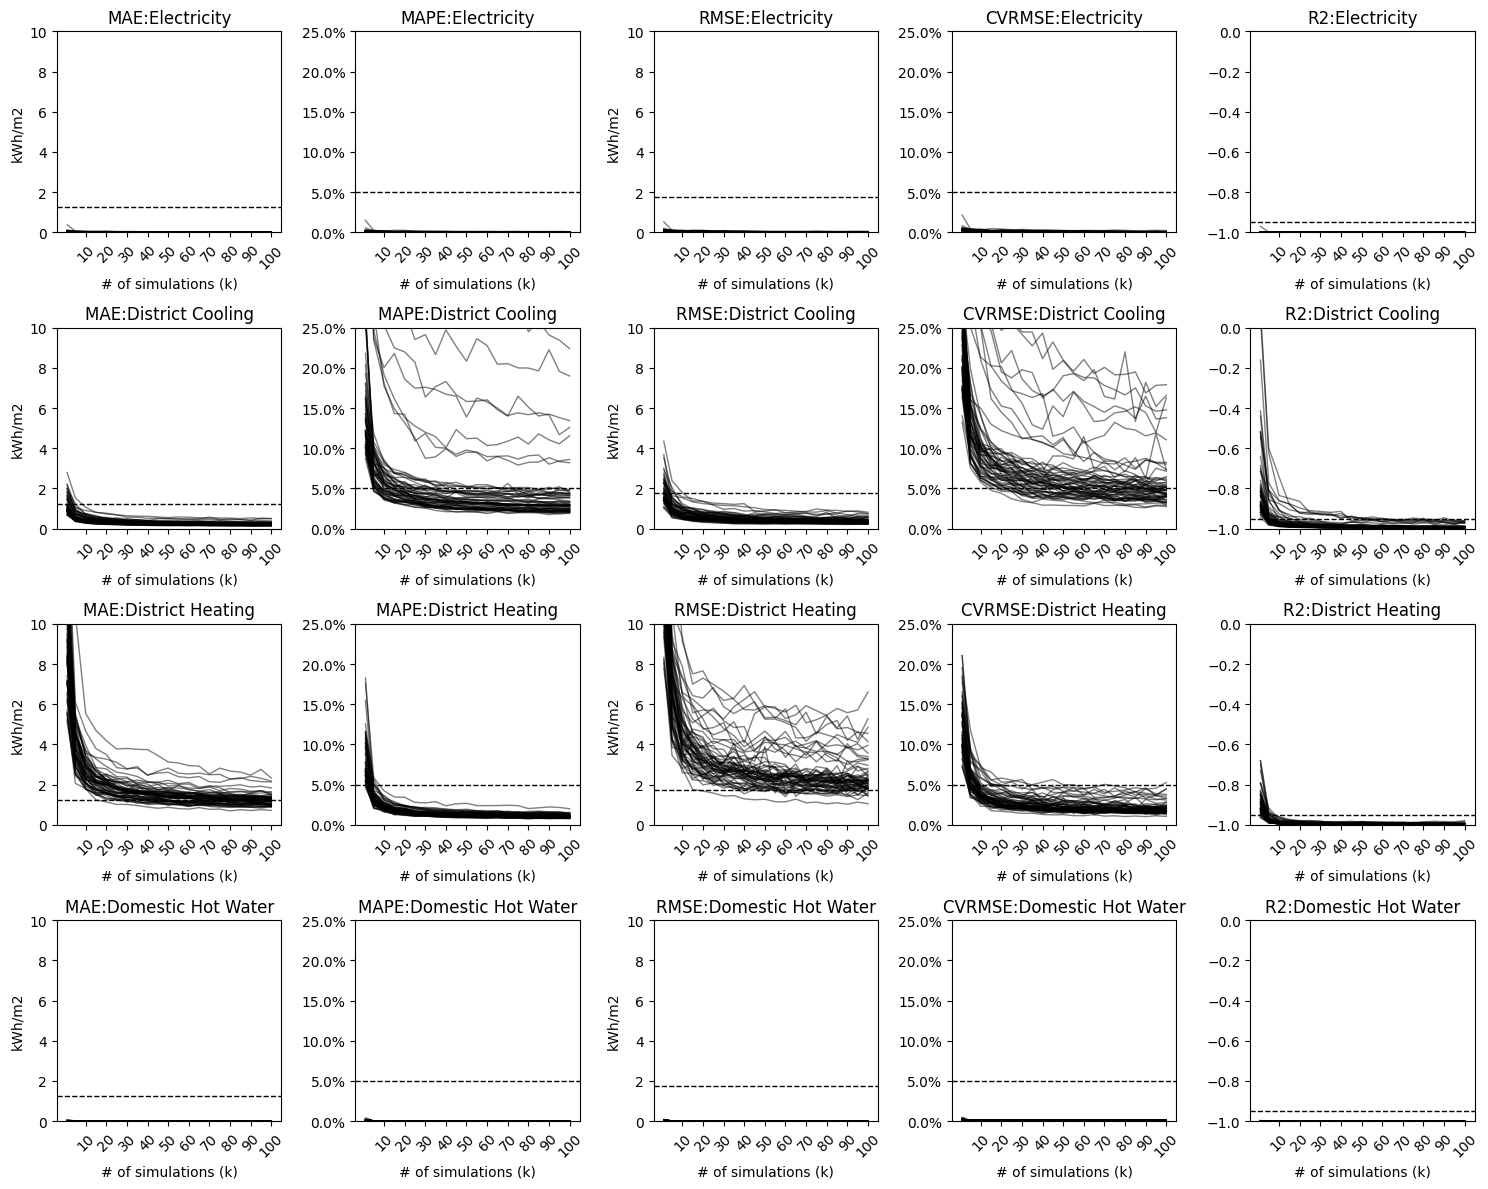

In [49]:
import matplotlib.pyplot as plt

# import the necesssary formatters for percentages
from matplotlib.ticker import PercentFormatter

axis_ylims = {
    "mae": (0, 10),
    "mape": (0, 0.25),
    "rmse": (0, 10),
    "cvrmse": (0, 0.25),
    "r2": (-1, 0),
}
axis_units = {
    "mae": "kWh/m2",
    "mape": "%",
    "rmse": "kWh/m2",
    "cvrmse": "%",
    "r2": "",
}
fig, ax = plt.subplots(
    len(target_columns),
    all_err_dfs.shape[1],
    figsize=(
        3 * all_err_dfs.shape[1],
        3 * len(target_columns),
    ),
)

for j, col in enumerate(target_columns):
    for i, metric in enumerate(all_err_dfs.columns):
        for k, epw_code in enumerate(
            all_err_dfs.index.get_level_values("epw_code").unique()
        ):
            data = all_err_dfs.loc[(slice(None), epw_code, col), metric]
            x = data.index.get_level_values("sample_frac")
            y = data.values
            ax[j, i].plot(x, y, lw=1, color="k", alpha=0.5)

        ax[j, i].set_title(f"{metric.upper()}:{col}")
        ax[j, i].set_ylim(*axis_ylims[metric])
        if axis_units[metric] == "%":
            ax[j, i].yaxis.set_major_formatter(PercentFormatter(1))
        else:
            ax[j, i].set_ylabel(axis_units[metric])

        ax[j, i].axhline(err_comparator[metric], color="k", ls="--", lw=1)
        ax[j, i].set_xlabel("# of simulations (k)")
        x_tick_locs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        x_tick_labels = [f"{int((x_i * n) // 1000)}" for x_i in x_tick_locs]
        ax[j, i].set_xticks(x_tick_locs, x_tick_labels, rotation=45)

fig.tight_layout()


In [ ]:
err_dfs = {}
for epw in unique_epws:
    mask = X_test["epwzip_path"] == epw
    epw_code = X_test_features["epw_code"][mask].iloc[0]
    dmat = xgb.DMatrix(X_test_features[mask], label=Y_test[target_columns].values[mask])
    err_dfs[epw_code] = compute_errs(
        model,
        X_test_features[mask],
        Y_test[target_columns].values[mask],
        target_columns,
    )


err_dfs = pd.concat(err_dfs, axis=1, names=["epw_code"]).T
(err_dfs < err_comparator).any(axis=1).groupby(level="epw_code").all().all()

err_dfs.round(2)

metric                        mae  mape  rmse  cvrmse    r2
epw_code target                                            
0        Electricity         0.01  0.00  0.02    0.00 -1.00
         District Cooling    0.18  0.02  0.30    0.04 -0.99
         District Heating    1.05  0.01  2.62    0.02 -1.00
         Domestic Hot Water  0.01  0.00  0.01    0.00 -1.00
1        Electricity         0.01  0.00  0.01    0.00 -1.00
...                           ...   ...   ...     ...   ...
57       Domestic Hot Water  0.01  0.00  0.02    0.00 -1.00
58       Electricity         0.01  0.00  0.01    0.00 -1.00
         District Cooling    0.48  0.04  0.72    0.07 -0.98
         District Heating    1.13  0.01  1.62    0.02 -1.00
         Domestic Hot Water  0.01  0.00  0.02    0.00 -1.00

[236 rows x 5 columns]

In [ ]:
passing = (err_dfs < err_comparator).any(axis=1).groupby(level="epw_code").all()
failures = (err_dfs < err_comparator).any(axis=1).loc[passing.index[~passing]]

failed_epw_codes = failures.index.get_level_values("epw_code")
failures, err_dfs.loc[failures[~failures].index].round(2)

Series([], dtype: bool)

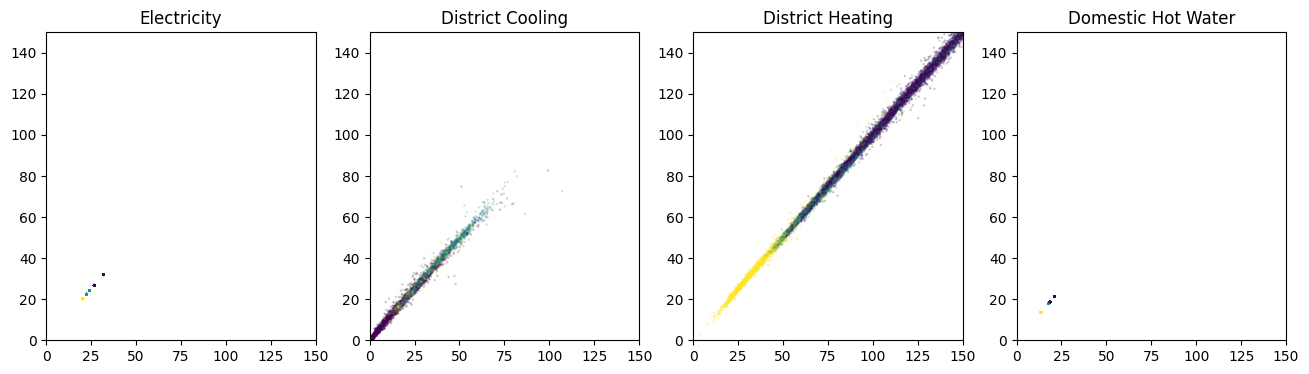

In [284]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, len(target_columns), figsize=(4 * len(target_columns), 4))
for epw in unique_epws:
    mask = X_test["epwzip_path"] == epw
    epw_code = X_test_features["epw_code"][mask].iloc[0]
    dmat = xgb.DMatrix(X_test_features[mask], label=Y_test[target_columns].values[mask])
    Y_preds = model.predict(dmat)
    Y_true = Y_test[target_columns].values[mask]
    X_test_features_masked = X_test_features[mask]
    colors = X_test_features_masked["year_bracket"].values
    # colors = X_test_features_masked["typology"].values
    # colors = X_test_features_masked["angle_sin"].values
    # colors = X_test_features_masked["angle_cos"].values
    # colors = X_test_features_masked["year_built"].values
    for i, col in enumerate(target_columns):
        ax[i].scatter(Y_true[:, i], Y_preds[:, i], alpha=0.2, s=0.5, c=colors)
        ax[i].set_title(col)
        ax[i].set_xlim(0, 150)
        ax[i].set_ylim(0, 150)


In [285]:
err_df = compute_errs(
    model, X_test_features, Y_test[target_columns].values, target_columns
)
err_df.round(2).T

metric,mae,mape,rmse,cvrmse,r2
target,,,,,
Electricity,0.01,0.00,0.02,0.00,-1.00
District Cooling,0.20,0.04,0.39,0.05,-0.99
District Heating,1.17,0.01,3.12,0.03,-1.00
Domestic Hot Water,0.01,0.00,0.01,0.00,-1.00


In [275]:
(err_comparator > err_df.T).any(axis=1)

target
Electricity           True
District Cooling      True
District Heating      True
Domestic Hot Water    True
dtype: bool

In [279]:
err_df.round(2).T

metric,mae,mape,rmse,cvrmse,r2
target,,,,,
Electricity,0.01,0.00,0.02,0.00,-1.00
District Cooling,0.24,0.05,0.43,0.06,-0.99
District Heating,1.37,0.01,3.27,0.03,-1.00
Domestic Hot Water,0.01,0.00,0.01,0.00,-1.00


In [267]:
err_df.round(2).T

metric,mae,mape,rmse,cvrmse,r2
target,,,,,
Electricity,0.01,0.00,0.03,0.00,-1.00
District Cooling,0.22,0.04,0.44,0.06,-0.99
District Heating,1.33,0.01,3.36,0.03,-1.00
Domestic Hot Water,0.01,0.00,0.02,0.00,-1.00


In [247]:
err_df.round(2).T


metric,mae,mape,rmse,cvrmse,r2
target,,,,,
Electricity,0.01,0.00,0.02,0.00,-1.00
District Cooling,0.40,0.07,0.63,0.08,-0.98
District Heating,1.44,0.01,3.44,0.03,-0.99
Domestic Hot Water,0.01,0.00,0.01,0.00,-1.00
